In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

import spacy
import nltk
import nltk.data
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import regex as re
import string
from collections import defaultdict

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

from gensim.models import FastText
from gensim.models.keyedvectors import KeyedVectors

import itertools


In [2]:
df = pd.read_csv('../data/input_tweets.csv')
print(df.head())

   Unnamed: 0         username  \
0           0  cristia89872894   
1           2      sccristiano   
2          12      Atorrante15   
3          16          _fedenb   
4          20  javier_eduardo3   

                                                                                                                                         acctdesc  \
0  Hincha del Apruebo, pero nunca de los Apruebistas...mi izquierda llega sólo hasta Mujica. Me gustan los chistes sobre estupideces posmodernas.   
1                                                                                                                                             NaN   
2                                                                                                                                             NaN   
3                                                                                                                           🍃ρєя αsρєяα α∂ αsтяα💫   
4                                                 

In [3]:
df.drop(columns = ['Unnamed: 0', 'acctdesc' ,'location', 'following', 'followers', 'totaltweets', 'usercreatedts', 'tweetcreatedts', 'retweetcount', 'hashtags', ], inplace = True)
print(df.head(5))

          username  \
0  cristia89872894   
1      sccristiano   
2      Atorrante15   
3          _fedenb   
4  javier_eduardo3   

                                                                                                                                                                                                                                                                            text  \
0                                                              @liznorthon @SoyAIvaro @ursulaeggers @MielyMerken @AlessandriFelip Pillaron al presunto, es de nacionalidad colombiana. No es sorpresa, la violencia es parte del inmigrante de origen colombiano, es su cultura.   
1                                                                                                                                   @ccarvajaly Cuando se den cuenta que eran homicidas o narco y los pillen dirán hemos dado con este inmigrante ilegal que era un delincuente.   
2                                      

In [4]:
df_train, df_test = train_test_split(df, test_size = 0.3, random_state = 42)

print(f'Training set shape: {df_train.shape}')
print(f'Test set shape: {df_test.shape}')

Training set shape: (1400, 3)
Test set shape: (600, 3)


In [5]:
punctuations = "¡!#$%&'()*+,-./:;<=>¿?@[\]^_`{|}~"

def read_txt(filename):
    list = []
    with open(filename, 'r', encoding='utf-8') as f:
        data = f.readlines()
        for line in data:
            list.append(str(line).replace('\n', ''))
    return list

stopwords = read_txt('../data/spanish_stopwords.txt')

stemmer = SnowballStemmer('spanish')

In [6]:
def clean_accents(tweet):
    tweet = re.sub(r"[àáâãäå]", "a", tweet)
    tweet = re.sub(r"ç", "c", tweet)
    tweet = re.sub(r"[èéêë]", "e", tweet)
    tweet = re.sub(r"[ìíîï]", "i", tweet)
    tweet = re.sub(r"[òóôõö]", "o", tweet)
    tweet = re.sub(r"[ùúûü]", "u", tweet)
    tweet = re.sub(r"[ýÿ]", "y", tweet)

    return tweet

def clean_tweet(tweet, stem = False):
    tweet = tweet.lower().strip()
    tweet = re.sub(r'https?:\/\/\S+', '', tweet)
    tweet = re.sub(r'http?:\/\/\S+', '', tweet)
    tweet = re.sub(r'www?:\/\/\S+', '', tweet)
    tweet = re.sub(r'\s([@#][\w_-]+)', "", tweet)
    tweet = re.sub(r"\n", " ", tweet)
    tweet = clean_accents(tweet)
    tweet = re.sub(r"\b(a*ha+h[ha]*|o?l+o+l+[ol]*|x+d+[x*d*]*|a*ja+[j+a+]+)\b", "<risas>", tweet)
    for symbol in punctuations:
        tweet = tweet.replace(symbol, "")
    tokens = []
    for token in tweet.strip().split():
        if token not in punctuations and token not in stopwords:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)


In [7]:
df['text_cleaned'] = df['text'].apply(lambda s : clean_tweet(s))
df_train['text_cleaned'] = df_train['text'].apply(lambda s : clean_tweet(s))
df_test['text_cleaned'] = df_test['text'].apply(lambda s : clean_tweet(s))

print(df_train['text_cleaned'].head(5))

e:\archivos de programa\python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
e:\archivos de programa\python\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


836                                                             palesmartfon sal cis tezan preocup sub impuest pag hotelit vien pater o dilapid chiringuit feminazis util algun
575     polishembassyuk ayud men pag cobij ayud okup ocup cas español ayud imigr pater hotel tod luj gobiern dej tir camioner español graci dem pais polit ayud nuestr camioner
557                                                                                         tard men african pater marruec arguineguin camioner español dov esper cruz roj lleg
1235                                                                                                             tambi aunqu asi esper vez van hab asient quier mio niet inmigr
1360                                                               manuelsancheze1 aca españ llam mor mierd o sudac obvi aunqu no pel falt sacud o sacud mediasper limpi no vas
Name: text_cleaned, dtype: object


In [8]:
df_train.drop_duplicates(subset=['text_cleaned'], keep='last', inplace = True)
df_test.drop_duplicates(subset=['text_cleaned'], keep='last', inplace = True)
df.drop_duplicates(subset=['text_cleaned'], keep='last', inplace = True)

e:\archivos de programa\python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
e:\archivos de programa\python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


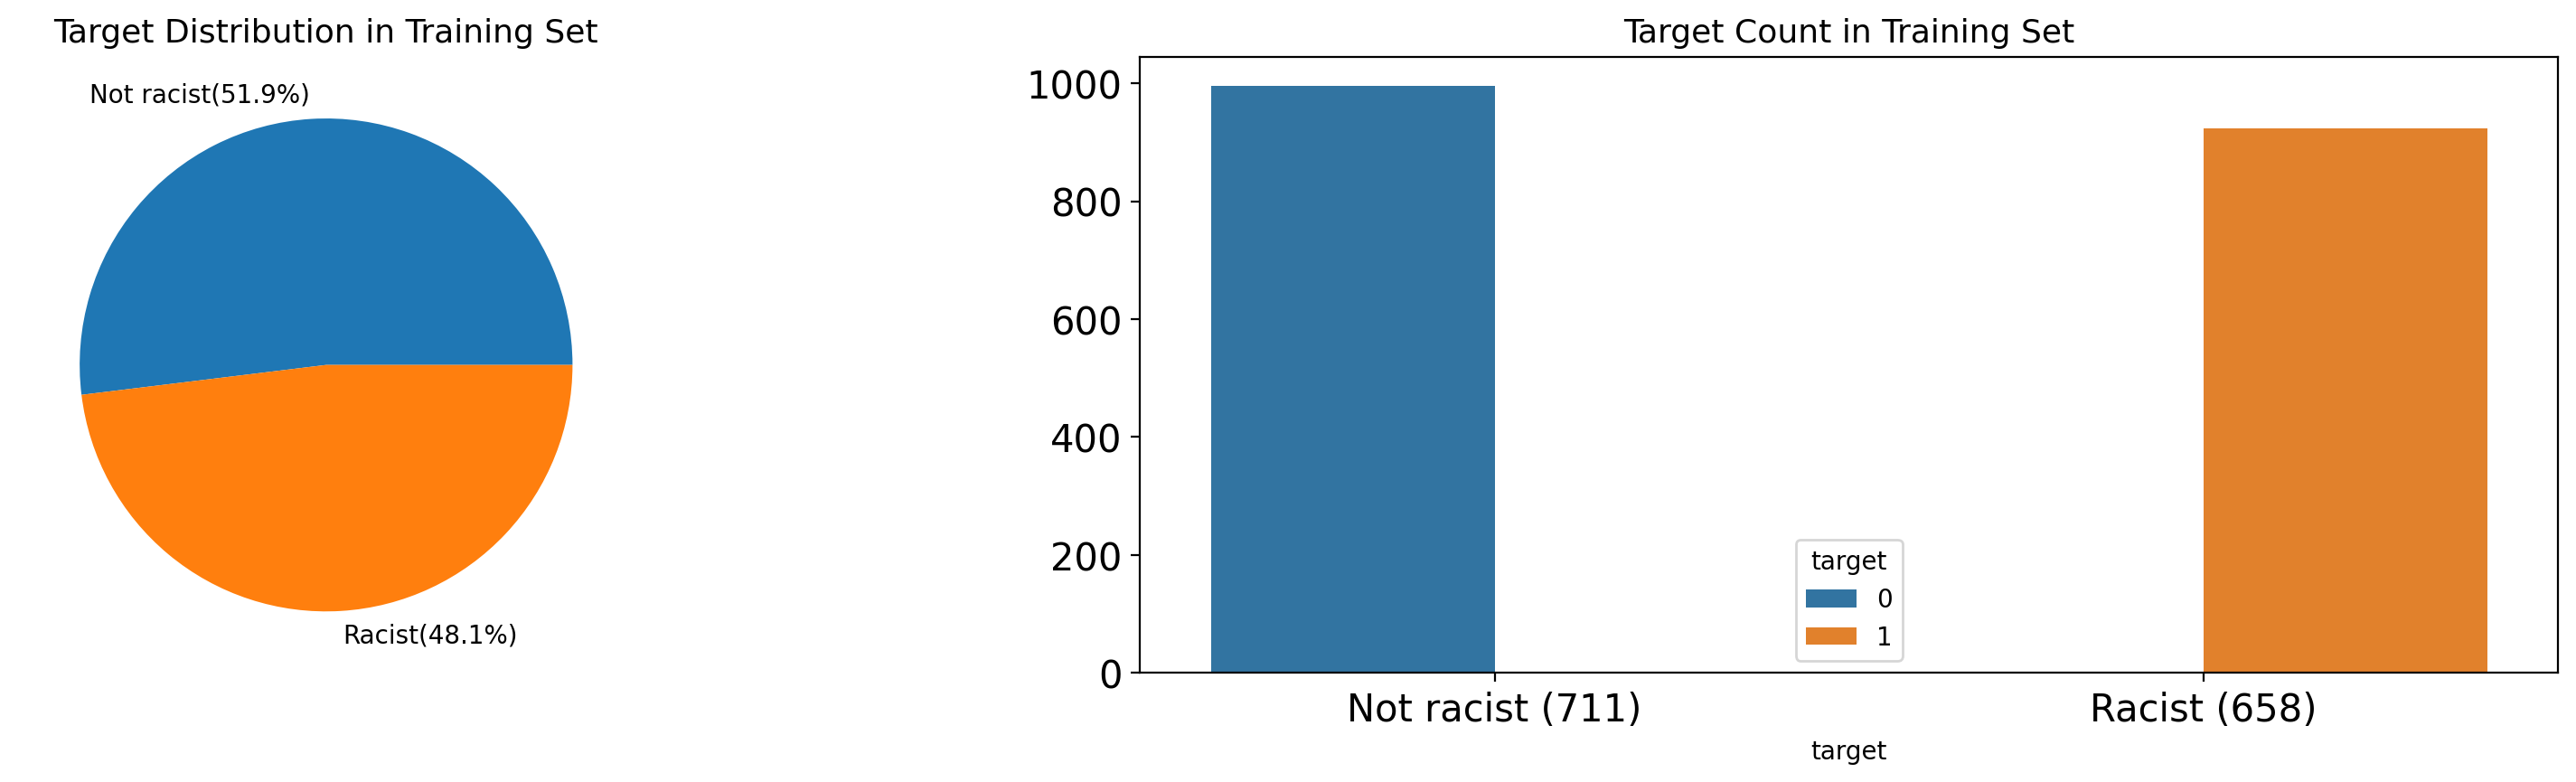

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=200)
plt.tight_layout()

target_count = df_train.groupby('target').count()['username']
not_racist_pct = round(target_count[0]/(target_count[0] + target_count[1]),3)
racist_pct = 1 - not_racist_pct

target_count.plot(kind='pie', ax=axes[0], labels=[f'Not racist({not_racist_pct*100}%)', f'Racist({racist_pct*100}%)'])
sns.countplot(x=df['target'], hue=df['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels([f'Not racist ({target_count[0]})', f'Racist ({target_count[1]})'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

In [10]:
def generate_ngrams(text, n_gram, stopwords):
  words = [w for w in text.lower().split(' ') if w != '' if w not in stopwords]
  if len(words) < n_gram:
    return []
  else:
    result = []
    for i in range(len(words) - n_gram+1):
      gram = ""
      for word in words[i:i+n_gram]:
        gram += word + " "
      gram = gram[:-1]
      result.append(gram)
    return result

In [11]:
N = 15
racist_tweets = df_train['target'] == 1
#Unigrams
racist_unigrams = defaultdict(int)
nonracist_unigrams = defaultdict(int)

for tweet in df_train[racist_tweets]['text_cleaned']:
  for word in generate_ngrams(tweet, 1, stopwords):
    racist_unigrams[word] += 1

for tweet in df_train[~racist_tweets]['text_cleaned']:
  for word in generate_ngrams(tweet, 1, stopwords):
    nonracist_unigrams[word] += 1

df_racist_unigrams = pd.DataFrame(sorted(racist_unigrams.items(), key=lambda x: x[1])[::-1])
df_nonracist_unigrams = pd.DataFrame(sorted(nonracist_unigrams.items(), key=lambda x: x[1])[::-1])

#Bigrams
racist_bigrams = defaultdict(int)
nonracist_bigrams = defaultdict(int)

for tweet in df_train[racist_tweets]['text_cleaned']:
  for word in generate_ngrams(tweet, 2, stopwords):
    racist_bigrams[word] += 1

for tweet in df_train[~racist_tweets]['text_cleaned']:
  for word in generate_ngrams(tweet, 2, stopwords):
    nonracist_bigrams[word] += 1

df_racist_bigrams = pd.DataFrame(sorted(racist_bigrams.items(), key=lambda x: x[1])[::-1])
df_nonracist_bigrams = pd.DataFrame(sorted(nonracist_bigrams.items(), key=lambda x: x[1])[::-1])

#Trigrams
racist_trigrams = defaultdict(int)
nonracist_trigrams = defaultdict(int)

for tweet in df_train[racist_tweets]['text_cleaned']:
  for word in generate_ngrams(tweet, 3, stopwords):
    racist_trigrams[word] += 1

for tweet in df_train[~racist_tweets]['text_cleaned']:
  for word in generate_ngrams(tweet, 3, stopwords):
    nonracist_trigrams[word] += 1

df_racist_trigrams = pd.DataFrame(sorted(racist_trigrams.items(), key=lambda x: x[1])[::-1])
df_nonracist_trigrams = pd.DataFrame(sorted(nonracist_trigrams.items(), key=lambda x: x[1])[::-1])

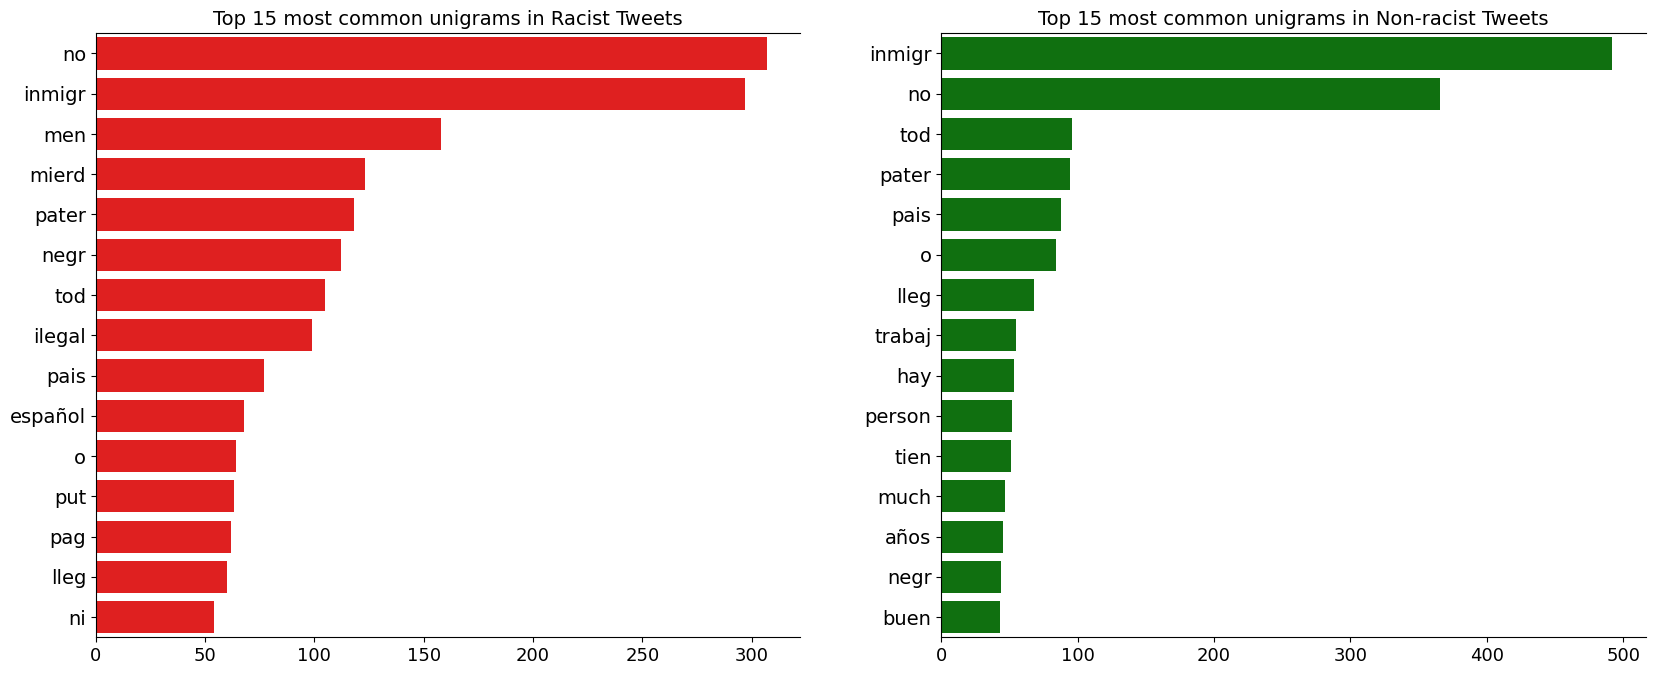

In [12]:
# PLot unigrams
fig, axes = plt.subplots(ncols=2, figsize=(20, 8), dpi=100)

sns.barplot(y=df_racist_unigrams[0].values[:N], x=df_racist_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nonracist_unigrams[0].values[:N], x=df_nonracist_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=14)

axes[0].set_title(f'Top {N} most common unigrams in Racist Tweets', fontsize=14)
axes[1].set_title(f'Top {N} most common unigrams in Non-racist Tweets', fontsize=14)

plt.show()

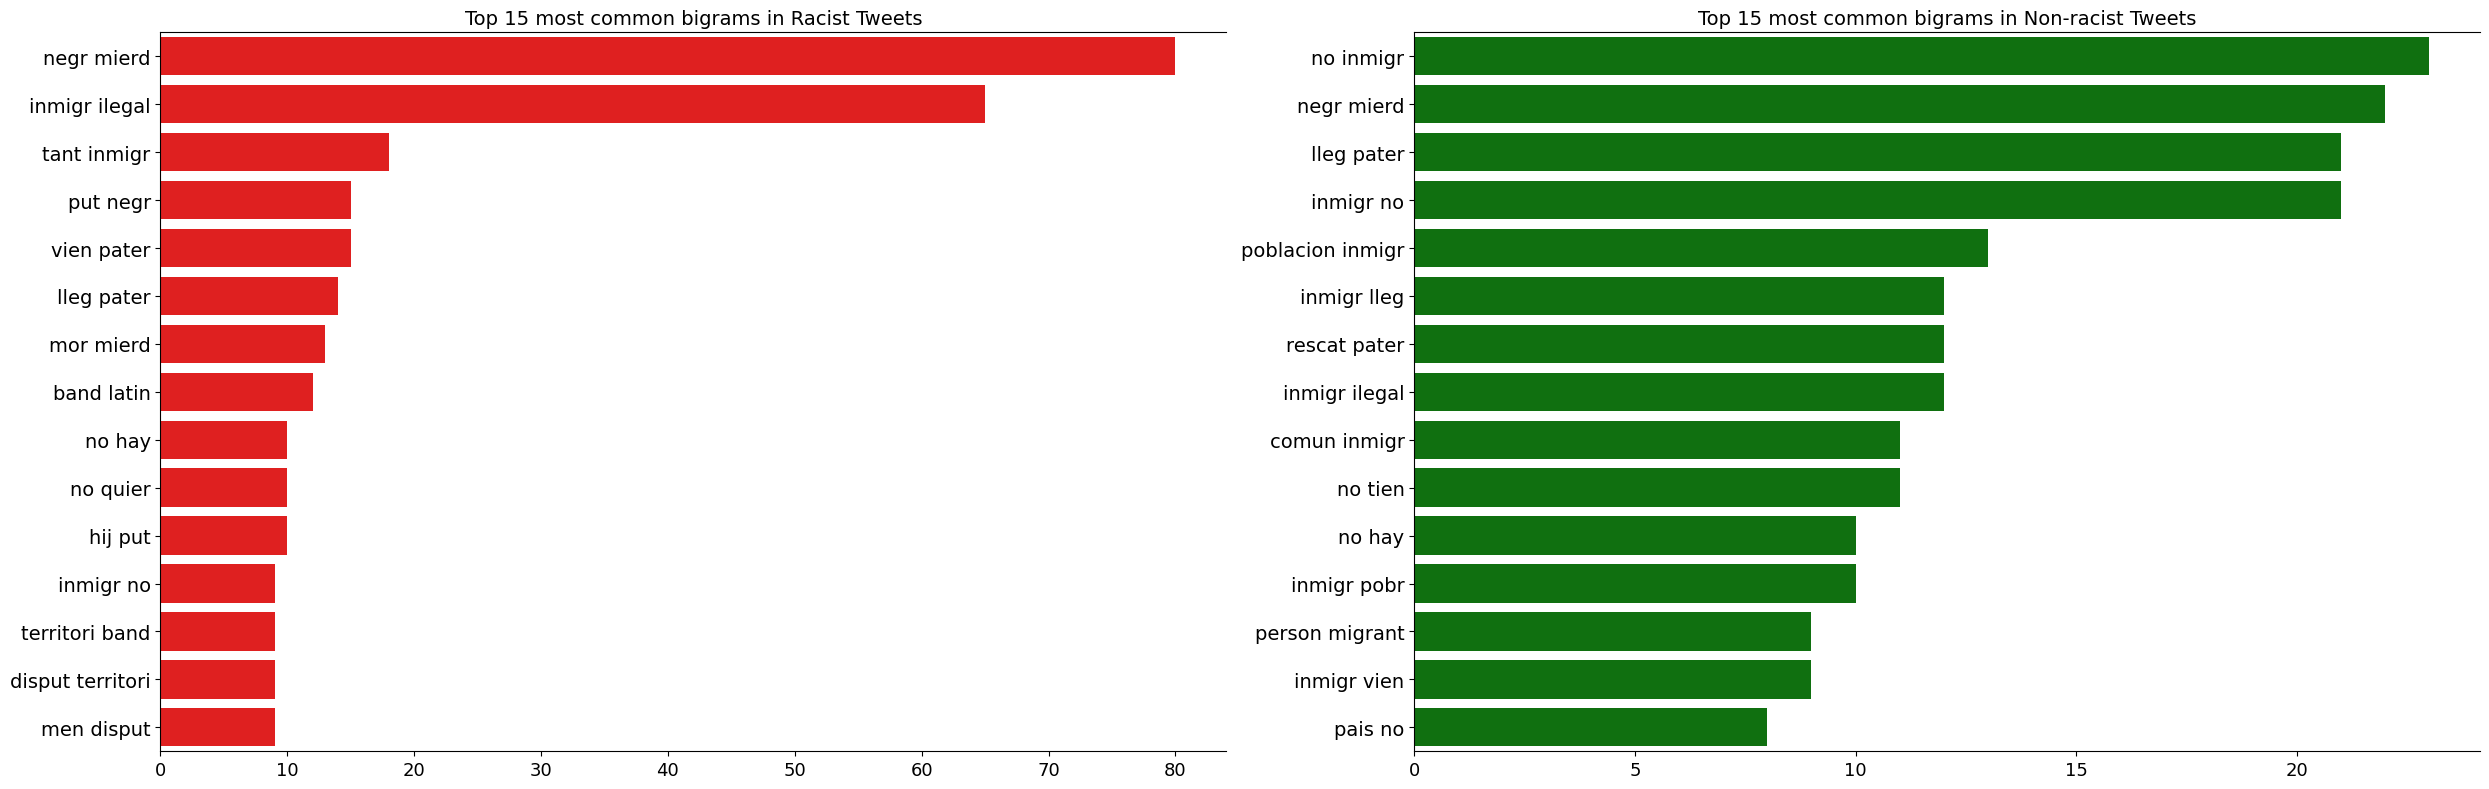

In [13]:
# PLot bigrams
fig, axes = plt.subplots(ncols=2, figsize=(25, 8), dpi=100)


sns.barplot(y=df_racist_bigrams[0].values[:N], x=df_racist_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nonracist_bigrams[0].values[:N], x=df_nonracist_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=14)

axes[0].set_title(f'Top {N} most common bigrams in Racist Tweets', fontsize=14)
axes[1].set_title(f'Top {N} most common bigrams in Non-racist Tweets', fontsize=14)
plt.tight_layout()
plt.show()

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text_cleaned)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 7149


In [15]:
MAX_SEQUENCE_LENGTH = 30
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text_cleaned),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text_cleaned),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)
print(x_train[0])

Training X Shape: (1369, 30)
Testing X Shape: (589, 30)
[   0    0    0    0    0    0    0    0    0    0    0    0    0 4437
   84 4438 4439  426  282  141   21 4440   23    3    8 4441  992 1296
 1716   76]


In [16]:
y_train = pd.DataFrame(df_train['target'])
y_test = pd.DataFrame(df_test['target'])

print("Training y Shape:", y_train.shape)
print("Testing y Shape:", y_test.shape)

Training y Shape: (1369, 1)
Testing y Shape: (589, 1)


In [17]:
GLOVE_EMB = '../data/embeddings/embeddings-l-model.vec'
EMBEDDING_DIM = 300
LR = 2e-3
BATCH_SIZE = 100
EPOCHS = 30

In [18]:
cantidad = 1313423
wordvectors = KeyedVectors.load_word2vec_format(GLOVE_EMB, limit=cantidad)

In [19]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = wordvectors[word]
        embedding_matrix[i] = embedding_vector
    except:
        pass

print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.088195   -0.25042999  0.09532    ... -0.042793    0.20156001
  -0.12804   ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [20]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [21]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [22]:
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [23]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on CPU...


In [24]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/30
14/14 [==============================] - 7s 124ms/step - loss: 0.6935 - accuracy: 0.5395 - val_loss: 0.6711 - val_accuracy: 0.6061

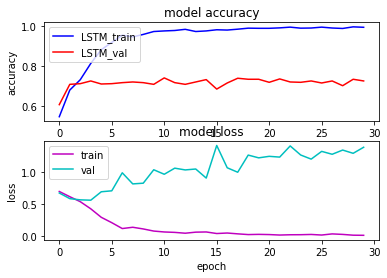

In [25]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [26]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

1/1 [==============================] - 0s 377ms/step


In [27]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

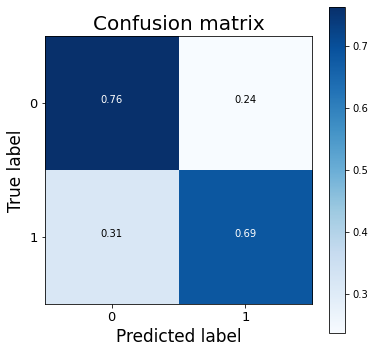

In [28]:
cnf_matrix = confusion_matrix(df_test.target, y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=df_test.target.unique(), title="Confusion matrix")
plt.show()

In [29]:
print(classification_report(list(df_test.target), y_pred_1d))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74       300
           1       0.74      0.69      0.71       289

    accuracy                           0.72       589
   macro avg       0.73      0.72      0.72       589
weighted avg       0.73      0.72      0.72       589

